# Determinación de tipos de estrellas.

Este segundo caso práctico consiste en desarrollar el algoritmo K–Means. Con el objetivo principal de identificar grupos dentro de los datos, utilizando este método. En esta práctica vamos a explorar diferentes técnicas de aprendizaje no supervisado con datos categóricos ordinales. 

**Autores:**

- 100471948 - Celia Patricio Ferrer
- 100472039 - Alberto García de la Torre

---
## Librerías necesarias.
---

In [93]:
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

# KMeans de sklearn 
from sklearn.cluster import KMeans
# KMedois de sklearn
from sklearn_extra.cluster import KMedoids
from sklearn.datasets import make_blobs

# Silhouette
from sklearn.metrics import silhouette_score

# Modelo
from sklearn.pipeline import make_pipeline

# Escalar datos
from sklearn.preprocessing import scale, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA

# Dendograma
from scipy.cluster.hierarchy import dendrogram

# Modelo jerarquico
from sklearn.cluster import AgglomerativeClustering

# Modelo DBSCAN
from sklearn.cluster import DBSCAN

# Modelo GMM
from sklearn.mixture import GaussianMixture

# Warnings
import warnings
warnings.filterwarnings('ignore')

---
## Lectura del archivo.
---

In [94]:
stars_df = pd.read_csv('stars2.csv')
# Visualizar las primeras filas del archivo
stars_df.head()

,Temperature,L,R,A_M,Color,Spectral_Class
0,3068,0.002400,0.1700,16.12,Red,M
1,3042,0.000500,0.1542,16.60,Red,M
2,2600,0.000300,0.1020,18.70,Red,M
3,2800,0.000200,0.1600,16.65,Red,M
4,1939,0.000138,0.1030,20.06,Red,M


Los atributos son:

- `Temperature`: temperatura promedio de la superficie (grados Kelvin).

- `L`: luminosidad en comparación con la del Sol.

- `R`: radio relativo en comparación con el del Sol.

- `A_M`: magnitud absoluta, brillo aparente de la estrella si estuviera a una distancia de 10 parsec.

- `Color`: color predominante en el espectro de la estrella.

- `Spectral_Class` o clasificación espectral: indicador que revela la presencia de elementos químicos en el espectro estelar.

### <u>Breve análisis de los datos</u>

Vamos a analizar brevemente el conjunto de datos con el que partimos. 

In [95]:
# Imprimir el tamaño del dataframe.
print("El tamaño es:")
print(stars_df.shape)

El tamaño es:
(240, 6)


In [96]:
# Imprimir el tipo de atributos.
stars_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Temperature     240 non-null    int64  
 1   L               240 non-null    float64
 2   R               240 non-null    float64
 3   A_M             240 non-null    float64
 4   Color           240 non-null    object 
 5   Spectral_Class  240 non-null    object 
dtypes: float64(3), int64(1), object(2)
memory usage: 11.4+ KB


**Categóricas o numéricas**

Ahora veremos si se tratan de columnas categóricas o columnas numéricas. En función de esto, cada una de estas columnas las deberemos manejar de una forma u otra.

In [97]:
cat_columns = stars_df.select_dtypes(include=['object']).columns
num_columns = stars_df.select_dtypes(include=['int64', 'float64']).columns

print("Columnas categoricas:", cat_columns)
print("Columnas numéricas:", num_columns)

Columnas categoricas: Index(['Color', 'Spectral_Class'], dtype='object')
Columnas numéricas: Index(['Temperature', 'L', 'R', 'A_M'], dtype='object')


---
## K–Means.
---

En esta primera sección, desarrollaremos la implementación de este algoritmo para contrastar los resultados y la eficiencia entre nuestra implementación y la proprocionada por *sklearn*.

In [99]:
""" Clase del KMeans implementado por nosotros """
class MiKMeans:
    def __init__(self, n_clusters=8, max_iter=300):
        self.n_clusters = n_clusters
        self.max_iter = max_iter

    """ Inicialización de centroides aleatorios """
    def init_centroids(self, X):
        centroids = []        # Lista de centroides
        # Seleccionar un punto aleatorio como primer centroide
        centroids.append(X[np.random.choice(X.shape[0])])

        # Iterar para seleccionar los centroides restantes
        for _ in range(1, self.n_clusters):
            # Calcular la distancia al cuadrado de cada punto al centroide más cercano
            dist_sq = np.array([min([np.inner(c-x,c-x) for c in centroids]) for x in X])
            # Calcular las probabilidades de selección de cada punto
            probs = dist_sq/dist_sq.sum()
            # Calcular las probabilidades acumuladas
            cumulative_probs = probs.cumsum()
            # Seleccionar un punto aleatorio
            r = np.random.rand()
            
            # Encontrar el índice del punto que será el próximo centroide
            for j, p in enumerate(cumulative_probs):
                if r < p:
                    i = j
                    break
            
            # Añadir el punto a la lista de centroides
            centroids.append(X[i])

        # Retornar los centroides
        return np.array(centroids)

    """ Método para entrenar el modelo """
    def fit(self, X):
        """ centroids_idx = np.random.choice(X.shape[0], size=self.n_clusters, replace=False)
        self.centroids = X[centroids_idx] """
        # Inicialización de centroides aleatorios
        self.centroids = self.init_centroids(X)

        # Iterar para ajustar los centroides
        for _ in range(self.max_iter):
            # Asignación de puntos al cluster más cercano
            distances = np.linalg.norm(X[:, np.newaxis] - self.centroids, axis=2)
            labels = np.argmin(distances, axis=1)

            # Actualización de centroides
            new_centroids = np.array([X[labels == k].mean(axis=0) for k in range(self.n_clusters)])

            # Comprobación de convergencia
            if np.allclose(self.centroids, new_centroids):
                break

            self.centroids = new_centroids

    """ Método para predecir el cluster de un conjunto de datos """
    def predict(self, X):
        distances = np.linalg.norm(X[:, np.newaxis] - self.centroids, axis=2)
        return np.argmin(distances, axis=1)

Esta implementación tiene un método `fit()` para entrenar el modelo y un método `predict()` para predecir las etiquetas de los datos de entrada.

### <u>Comparación</u>

En esta sección se comparan ambas implementaciones, la nuestra y la que ofrece SKlearn. Para esta comparación, la semilla elegida será el valor `0`, debido a que solo servirá para esta simulación inicial.

#### Make Blobs

Para la comparación de las dos implementaciones del algoritmo KMeans utilizaremos la simulación de datos generada  con `make_blobs()`, para que sea un conjunto de datos más sencillo.

Text(0.5, 1.0, 'Datos simulados')

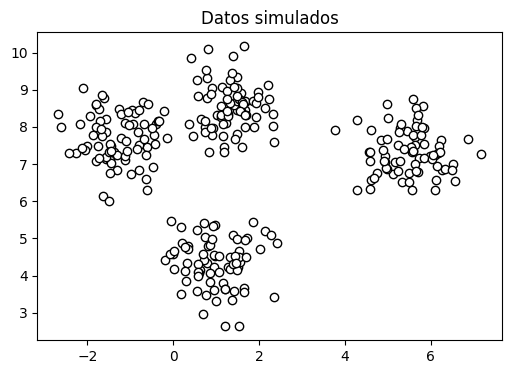

In [100]:
# Simulación de datos
X, y = make_blobs(
    n_samples    = 300,
    n_features   = 6,
    centers      = 4,
    cluster_std  = 0.60,
    shuffle      = True,
    random_state = 0
)

# Diagrama de dispersión
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.scatter(
    x = X[:, 0],
    y = X[:, 1],
    c = 'white',
    marker    = 'o',
    edgecolor = 'black',
)
ax.set_title('Datos simulados')

#### KMeans de SKlearn

In [101]:
# Modelo de sklearn
kmeans_sklearn = KMeans(n_clusters=4, n_init=25, random_state=0)
# Entrenar el modelo
t_inicio = time.time_ns()
kmeans_sklearn.fit(X)
t_fin = time.time_ns()
# Tiempo de entrenamiento
t_sklearn = t_fin - t_inicio

In [102]:
# Predicciones
y_pred_s = kmeans_sklearn.predict(X)

# Centroides
centroids_s = kmeans_sklearn.cluster_centers_

# Silhouette
score_s = silhouette_score(X, y_pred_s)

#### KMeans implementado

In [103]:
# Modelo implementado por nosotros
kmeans_custom = MiKMeans(n_clusters=4, max_iter=25)
# Entrenar el modelo
t_inicio = time.time_ns()
kmeans_custom.fit(X)
t_fin = time.time_ns()
# Tiempo de entrenamiento
t_custom = t_fin - t_inicio

In [104]:
# Predicciones
y_pred_c = kmeans_custom.predict(X)

# Centroides
centroids_c = kmeans_custom.centroids

# Silhouette
score_c = silhouette_score(X, y_pred_c)

#### Resultados

In [105]:
# Mostrar los tiempos de entrenamiento
print(f"KMeans de sklearn:")
print(f"Tiempo de entrenamiento: {t_sklearn:.2f} s")
print(f"Silhouette: {score_s:.2f}")
print()
print(f"KMeans implementado por nosotros:")
print(f"Tiempo de entrenamiento: {t_custom:.2f} s")
print(f"Silhouette: {score_c:.2f}")

KMeans de sklearn:
Tiempo de entrenamiento: 30283000.00 s
Silhouette: 0.84

KMeans implementado por nosotros:
Tiempo de entrenamiento: 6307000.00 s
Silhouette: 0.84


Obtenemos que el tiempo de entrenamiento de la implementación llevada a cabo por nosotros es significativamente más rápida que la implementación de KMeans de SKlearn. En terminos de tiempo de ejecución, podemos decir que nuestra implementación es mejor. Sin embargo, para ver si globalmente es mejor, deberemos estudiar la precisión y la calidad de los resultados que esta obtiene. 

Text(0.5, 1.0, 'Resultados con nuestro KMeans')

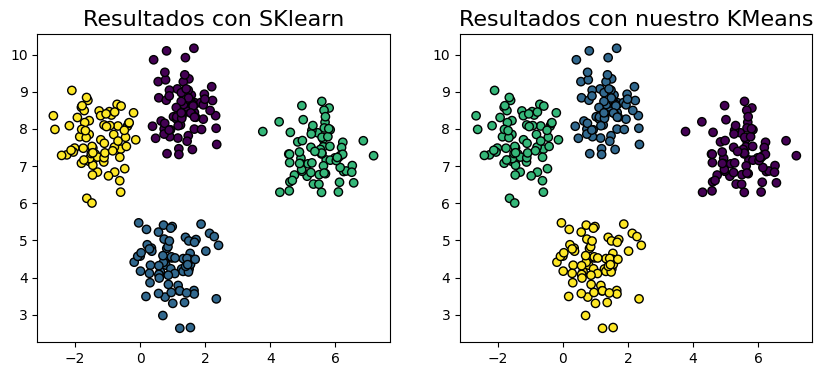

In [106]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

# Resultados para SKlearn
# ==============================================================================
ax[0].scatter(
    x = X[:, 0],
    y = X[:, 1],
    c = y_pred_s,
    cmap='viridis',
    marker    = 'o',
    edgecolor = 'black'
)
ax[0].set_title('Resultados con SKlearn', size=16)

# Resultados para nosotros
# ==============================================================================
ax[1].scatter(
    x = X[:, 0],
    y = X[:, 1],
    c = y_pred_c,
    cmap='viridis',
    marker    = 'o',
    edgecolor = 'black'
)
ax[1].set_title('Resultados con nuestro KMeans', size=16)

Como podemos ver, los datos de esta simulación en ambas implementaciones se dibujan de la misma manera. Esto significa que la implementación llevada a cabo por nosotros está funcionando como se espera, obteniendo unos resultados similares en ambos algoritmos.

---
## Variables categóricas.
---

Como hemos visto anteriormente, este problema cuenta con dos variables categóricas `Color` y `Spectral_Class`. Vamos a utilizar dos métodos de codificación para ver cual es el que se adapta mejor a los requisitos de nuestro problema, para posteriormente utilizarlo en los modelos que vamos a realizar.

### <u>One Hot Encoding</u>

En esta primera parte, trataremos las variables categóricas con la codificación `One–Hot–Encoding`. 

In [107]:
X_one = stars_df.copy()
# Realizar la codificación one-hot en las columnas categóricas
X_one = pd.get_dummies(X_one, columns=cat_columns, drop_first=True, dtype='int64')

In [108]:
# Escalar las columnas numéricas
X_scaled_one = scale(X=X_one, axis=0, with_mean=True, with_std=True)

### <u>Categóricas ordinales</u>

En esta segunda parte, trataremos como variables categóricas con la codificiación de variables categóricas ordinales para su posterior comparación con los resultados obtenidos de la forma anterior. 

In [109]:
X_ord = stars_df.copy()

spectral_class = ("O", "B", "A", "F", "G", "K", "M")
# Pasar columnas categóricas ordinales a numéricas
X_ord['Spectral_Class'] = X_ord['Spectral_Class'].map(lambda x: spectral_class.index(x))

# Convierte los colores
colors = ["Red", "Orange-Red", "Orange", "Pale yellow orange", "Yellowish", "yellow-white", "Whitish", "Yellowish White", "White-Yellow", "White", "Blue-white", "Blue"]

# Iterar todos los elementos y modificarlos
X_ord['Color'] = X_ord['Color'].replace("Blue White", "Blue-white")
X_ord['Color'] = X_ord['Color'].replace("Blue white", "Blue-white")
X_ord['Color'] = X_ord['Color'].replace("Blue-White", "Blue-white")
X_ord['Color'] = X_ord['Color'].replace("white", "White")
X_ord['Color'] = X_ord['Color'].replace("yellowish", "Yellowish")

# Pasar columnas categóricas ordinales a numéricas
X_ord['Color'] = X_ord['Color'].map(lambda x: colors.index(x))

Antes de nada, aplicaremos el método `scale` para estandarizar características eliminando la media y escalando a la varianza unitaria.

In [110]:
X_scaled_ord = scale(X=X_ord, axis=0, with_mean=True, with_std=True)

---
## Correlación.
---

Para realizar las matrices de correlación para proceder a realizar el análisis PCA, analizaremos la correlacion de los *dataframes* codificados con los dos métodos realizados. Para hacer esta matriz de correlación, deberemos utilizar los datos sin escalar de cada modelo.

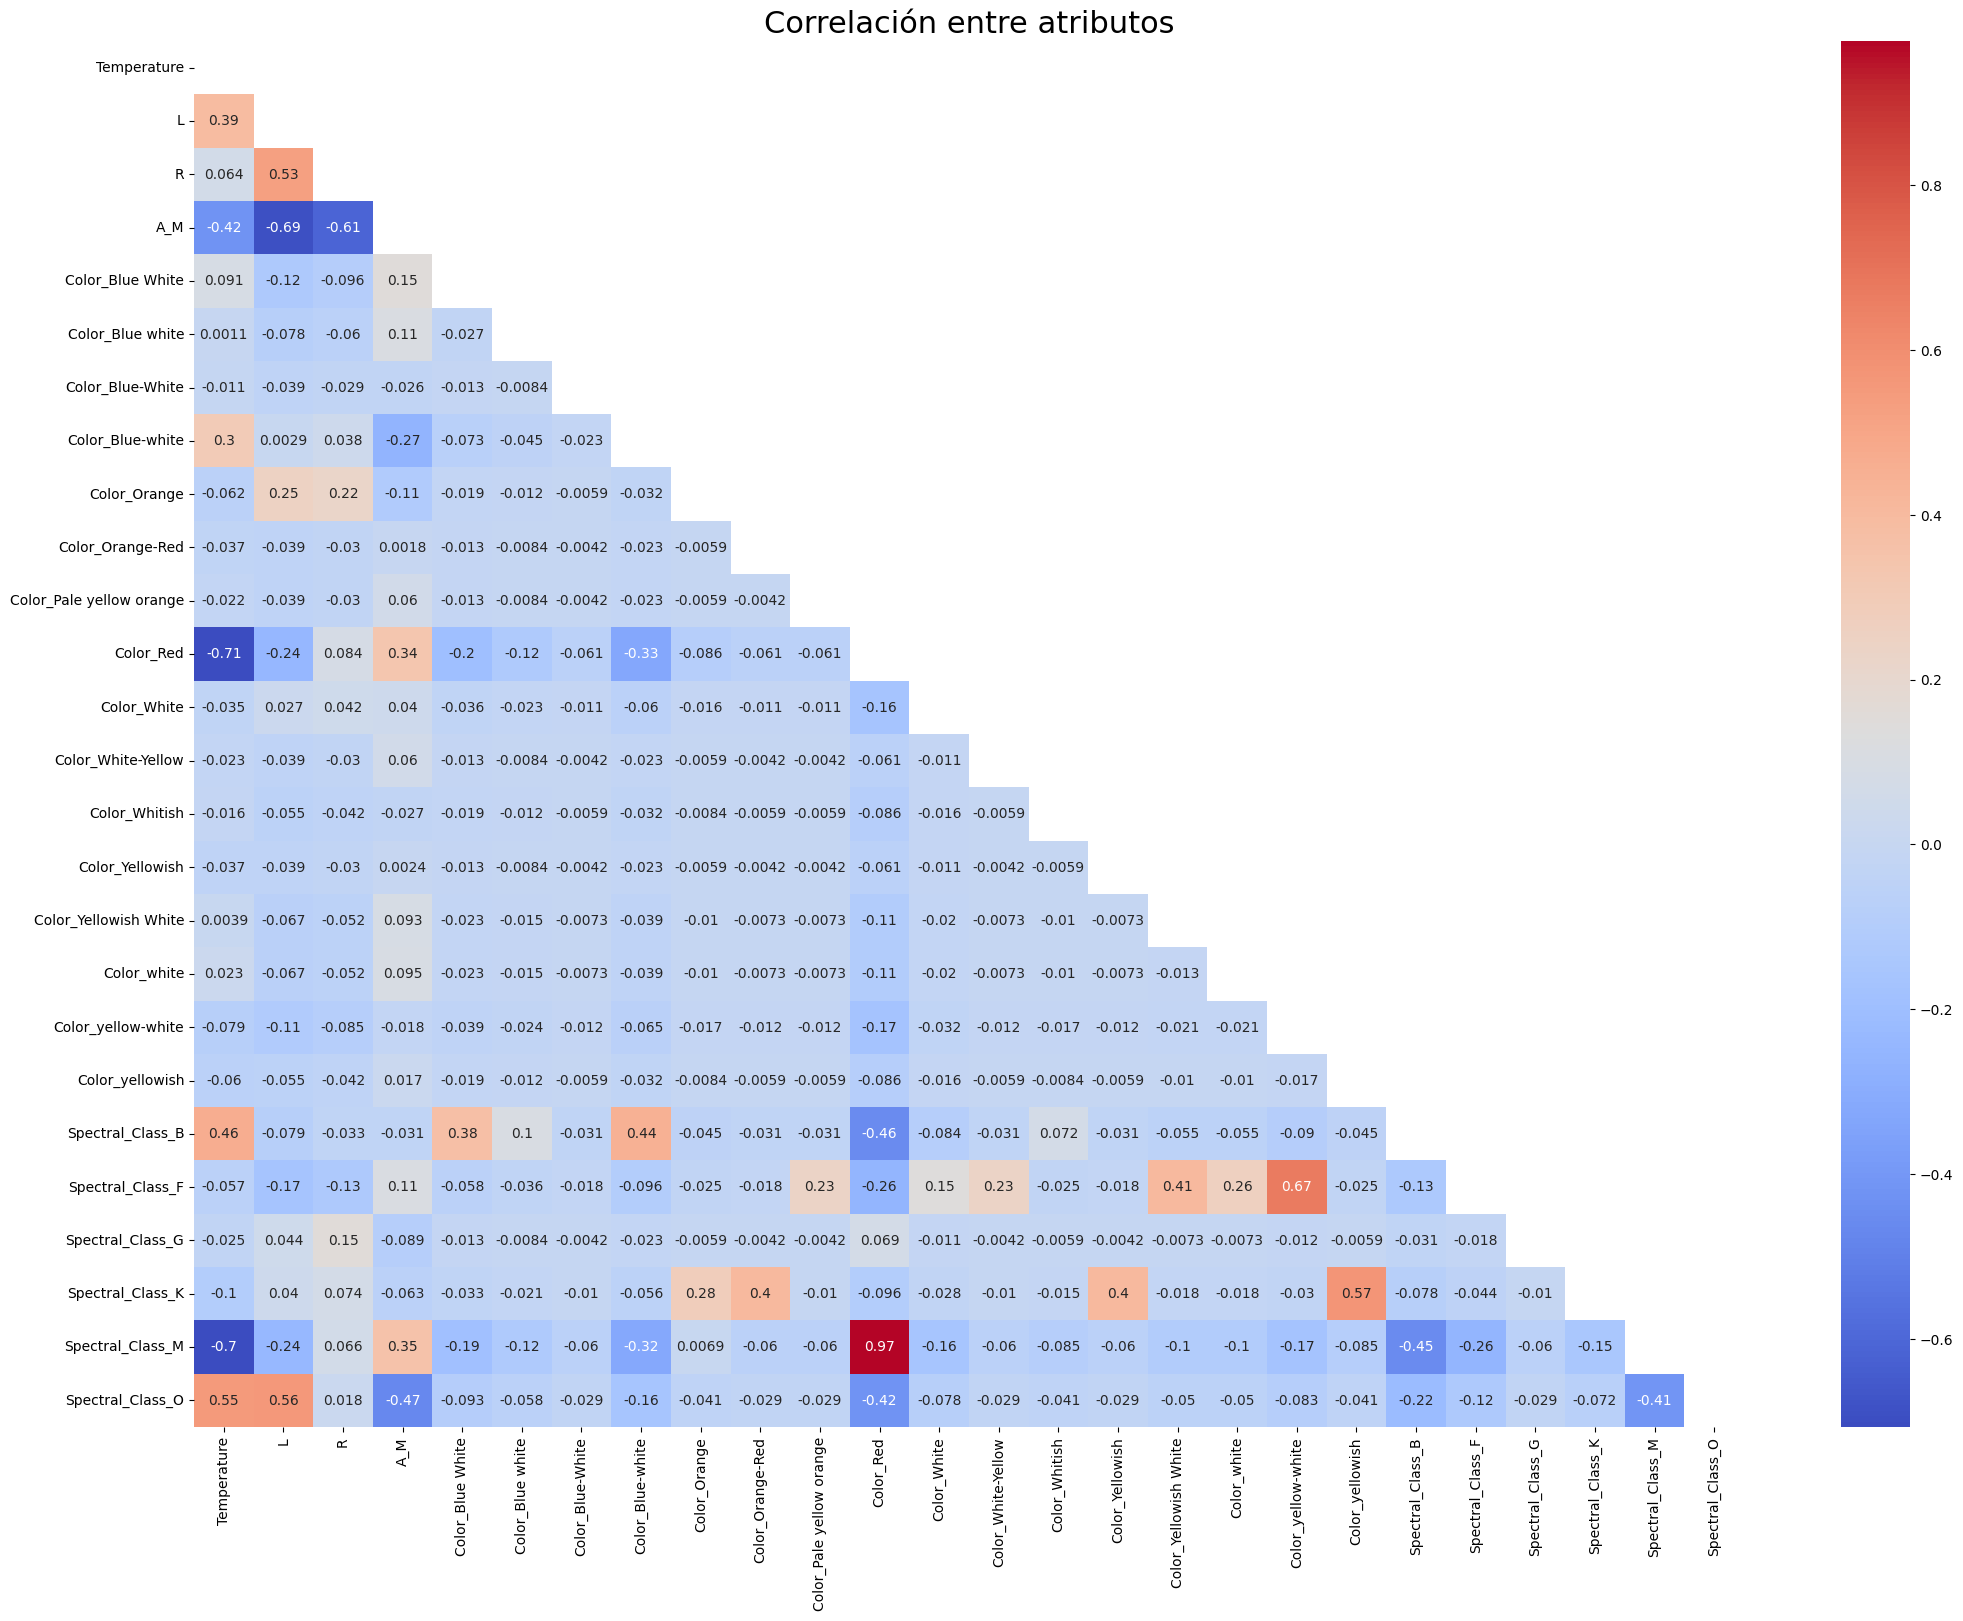

In [111]:
# Método One Hot Encoding
corr_df = X_one.corr()
etiquetas = corr_df.columns

mask_ut = np.triu(np.ones(corr_df.shape)).astype(bool)
plt.figure(figsize=(25, 18))  
sns.heatmap(corr_df, mask=mask_ut, annot=True, cmap="coolwarm")
plt.title("Correlación entre atributos", size=22)
plt.show()

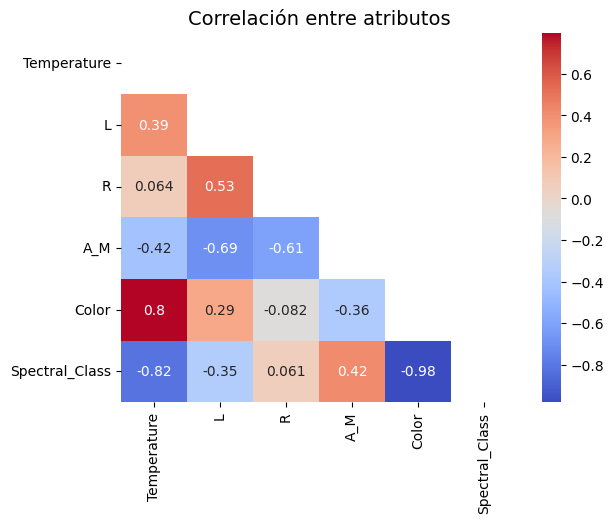

In [112]:
# Método Variables Ordinales
corr_df = X_ord.corr()
etiquetas = corr_df.columns

mask_ut = np.triu(np.ones(corr_df.shape)).astype(bool)
sns.heatmap(corr_df, mask=mask_ut, annot=True, cmap="coolwarm")
plt.title("Correlación entre atributos", size=14)
plt.show()

Como se puede ver, tenemos varios pares de variables con una alta correlación. Por lo tanto, se puede proceder a realizar el análisis PCA para transformar los datos de entrada y visualizarlos.

---
## Número de clusters.
---

Ahora procederemos a analizar con el modelo *KMeans* cuál obtiene un valor más aproximado al valor óptimo de clusters proporcionado por los científicos.

**Método silueta**

Utilizaremos este método para dibujar la gráfica con el valor óptimo de número de clusters dado por un modelo.

In [113]:
def metodo_silueta(range_n_clusters, inertias, best_n_clusters, max_silhouette_score):
    # Graficar
    fig, ax = plt.subplots(1, 1, figsize=(12, 10))
    ax.plot(range_n_clusters, inertias, marker='o', color='purple')
    ax.set_title("Evolución de media de los índices Silhouette", size=20)
    ax.set_xlabel('Número clusters', size=14)
    ax.set_ylabel('Media índices silhouette', size=14)

    # Mejor número de clusters
    ax.text(best_n_clusters, max_silhouette_score, f'Max', 
            verticalalignment='bottom', horizontalalignment='center', fontsize=16)

    # Agregar una cuadrícula
    ax.grid(True)

    plt.show()

**One Hot Encoding**

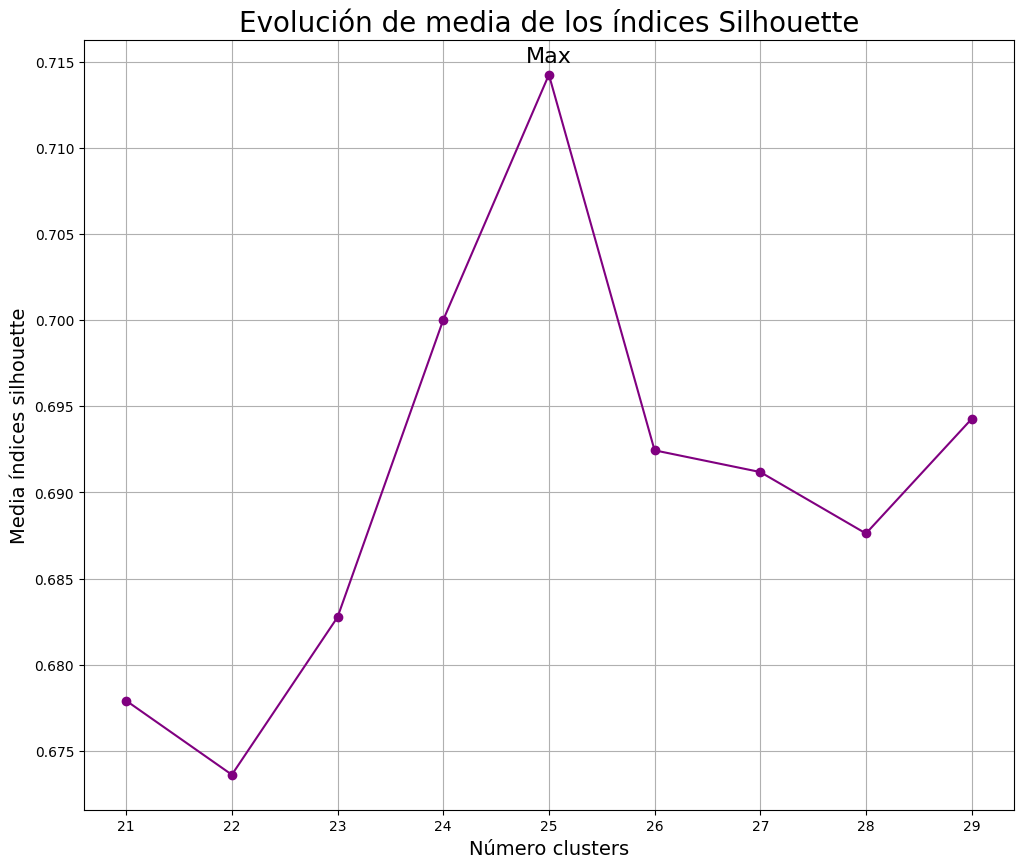

In [114]:
range_n_clusters = range(21, 30)
valores_medios_silhouette = []

for n_clusters in range_n_clusters:
    modelo = KMeans(
        n_clusters   = n_clusters,
        n_init       = 25,
        random_state = 49
    )
    cluster_labels = modelo.fit_predict(X_scaled_one)
    silhouette_avg = silhouette_score(X_scaled_one, cluster_labels)
    valores_medios_silhouette.append(silhouette_avg)

# Encontrar el número de clústeres con la puntuación de silueta máxima
max_silhouette_idx = np.argmax(valores_medios_silhouette)
max_silhouette_score = valores_medios_silhouette[max_silhouette_idx]
best_n_clusters = range_n_clusters[max_silhouette_idx]

# Método silueta para datos escalados
metodo_silueta(range_n_clusters, valores_medios_silhouette, best_n_clusters, max_silhouette_score+0.0005)

Con este método de codificación obtenemos un valor óptimo de número de clusters de 25. Este valor es demasiado alto y muy lejano al que proporcionan los científicos. Veremos con el otro método a ver si se obtiene algo mejor.

**Variables ordinales**

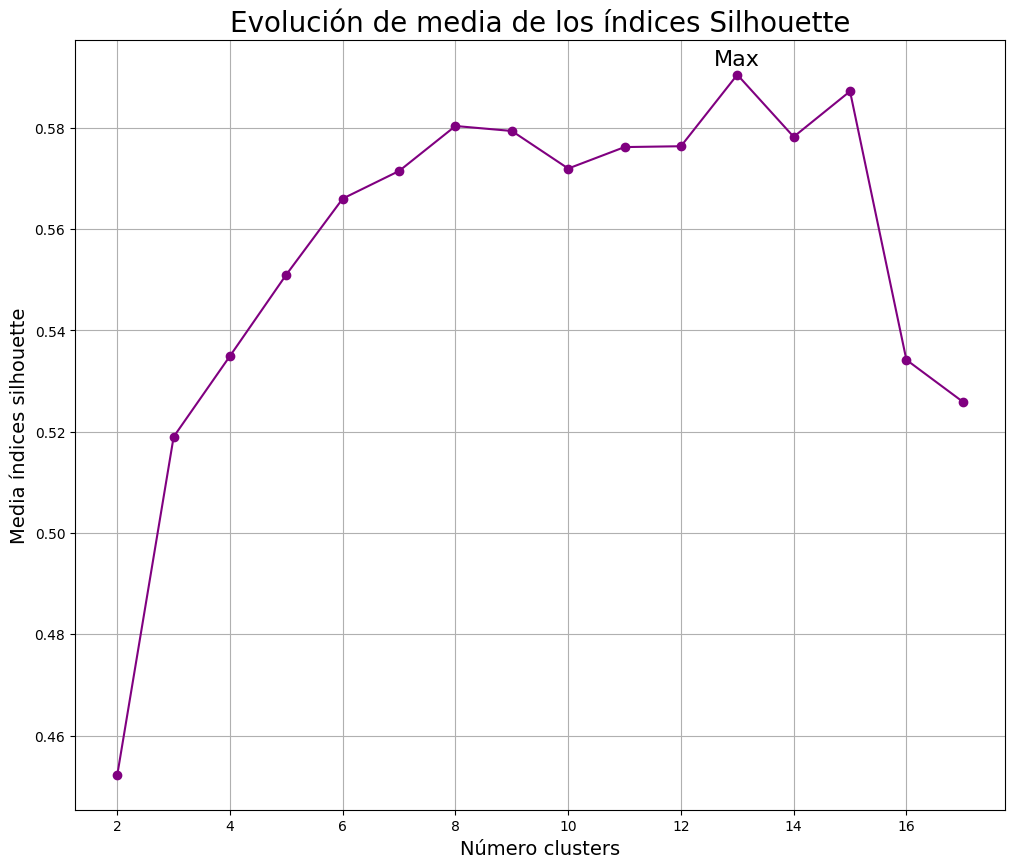

In [115]:
range_n_clusters = range(2, 18)
valores_medios_silhouette = []

for n_clusters in range_n_clusters:
    modelo = KMeans(
        n_clusters   = n_clusters,
        n_init       = 25,
        random_state = 49
    )
    cluster_labels = modelo.fit_predict(X_scaled_ord)
    silhouette_avg = silhouette_score(X_scaled_ord, cluster_labels)
    valores_medios_silhouette.append(silhouette_avg)

# Encontrar el número de clústeres con la puntuación de silueta máxima
max_silhouette_idx = np.argmax(valores_medios_silhouette)
max_silhouette_score = valores_medios_silhouette[max_silhouette_idx]
best_n_clusters = range_n_clusters[max_silhouette_idx]

# Método silueta para datos escalados
metodo_silueta(range_n_clusters, valores_medios_silhouette, best_n_clusters, max_silhouette_score+0.001)

Sin embargo, con este método se obtiene un resultado más próximo al esperado. Como vemos, el valor óptimo del número de clusters que se obtiene con este método de codificación es 13. Aunque si bien es cierto, el valor del silhouette entre 6 y 13 clusters es realmente próximo, siendo algo más a 0.56 con 6 clusters y algo más a 0.58 con 13 clusters. 

---
## PCA
---

Realizaremos esta última comprobación para finalmente decidir cuál método de codificación es más conveniente para nuestro problema.

**One Hot Encoding**

In [202]:
# Crear un dataframe con los datos escalados
X_scaled_one_df = pd.DataFrame(X_scaled_one, columns=X_one.columns, index=X_one.index)

In [203]:
np.set_printoptions(precision=2)
X = X_scaled_one_df.values.squeeze()
pca = PCA(n_components=2)
X_pca_one = pca.fit_transform(X)
df_pca_one = pd.DataFrame(X_pca_one, columns=['PC1','PC2'])
df_pca_one.head()

,PC1,PC2
0,-2.262021,0.133310
1,-2.279085,0.118610
2,-2.368815,0.056112
3,-2.291854,0.118397
4,-2.444133,0.017718


In [204]:
std = df_pca_one.describe().transpose()["std"]
print(f"Proporción de varianza explicada: {pca.explained_variance_ratio_}")
print(f"Proporción acumulada: {np.cumsum(pca.explained_variance_ratio_)}")

Proporción de varianza explicada: [0.15 0.1 ]
Proporción acumulada: [0.15 0.24]


La varianza explicada muestra que se explica el 15% en el primer componente y el 10% en el segundo componente, una suma del 24%, una varianza total.

<Axes: xlabel='PC1', ylabel='PC2'>

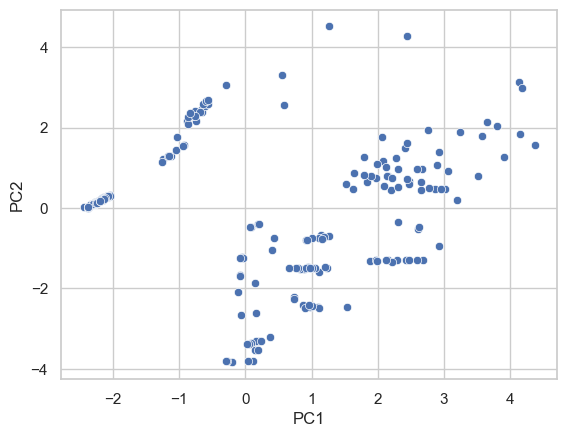

In [205]:
std = df_pca_one.describe().transpose()["std"]
sns.scatterplot(data=df_pca_one, x="PC1", y="PC2")

Al realizar diferentes comprobaciones con más números de componentes, se obtiene que la varianza explicada no llega al menos al 80% (considerando este valor, un buen valor). En este siguiente ejemplo se propone el caso de cinco componentes.

In [206]:
np.set_printoptions(precision=2)
X = X_scaled_one_df.values.squeeze()
pca = PCA(n_components=5)
X_pca_one = pca.fit_transform(X)
df_pca = pd.DataFrame(X_pca_one, columns=['PC1','PC2','PC3','PC4','PC5'])

In [207]:
std = df_pca_one.describe().transpose()["std"]
print(f"Proporción de varianza explicada: {pca.explained_variance_ratio_}")
print(f"Proporción acumulada: {np.cumsum(pca.explained_variance_ratio_)}")

Proporción de varianza explicada: [0.15 0.1  0.08 0.07 0.05]
Proporción acumulada: [0.15 0.24 0.32 0.39 0.45]


**Variables codificadas como ordinales**

In [208]:
# Crear un dataframe con los datos escalados
X_scaled_ord_df = pd.DataFrame(X_scaled_ord, columns=stars_df.columns, index=stars_df.index)

In [209]:
np.set_printoptions(precision=2)
X = X_scaled_ord_df.values.squeeze()
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
df_pca = pd.DataFrame(X_pca, columns=['PC1','PC2'])
df_pca.head()

,PC1,PC2
0,-2.067808,-0.147152
1,-2.087328,-0.165090
2,-2.188924,-0.236104
3,-2.101169,-0.161525
4,-2.273203,-0.273557


In [210]:
std = df_pca.describe().transpose()["std"]
print(f"Proporción de varianza explicada: {pca.explained_variance_ratio_}")
print(f"Proporción acumulada: {np.cumsum(pca.explained_variance_ratio_)}")

Proporción de varianza explicada: [0.55 0.3 ]
Proporción acumulada: [0.55 0.85]


Con dos componenetes obtenemos que un 85% de varianza explicada, un buen resultado.

<Axes: xlabel='PC1', ylabel='PC2'>

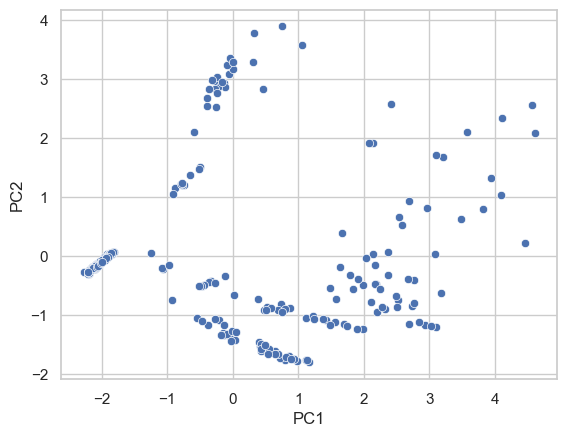

In [211]:
std = df_pca.describe().transpose()["std"]
sns.scatterplot(data=df_pca, x="PC1", y="PC2")

Pese haber obtenido un buen resultado, también probaremos a realizar la tranformación de los datos de entrada mediante un PCA de tres dimensiones.

In [212]:
np.set_printoptions(precision=2)
X = X_scaled_ord_df.values.squeeze()
pca = PCA(n_components=3)
X_trans3 = pca.fit_transform(X)
df_pca3 = pd.DataFrame(X_trans3, columns=['PC1','PC2', 'PC3'])
df_pca3.head()

,PC1,PC2,PC3
0,-2.067808,-0.147152,0.190962
1,-2.087328,-0.165090,0.195077
2,-2.188924,-0.236104,0.217676
3,-2.101169,-0.161525,0.198859
4,-2.273203,-0.273557,0.237536


In [213]:
std = df_pca3.describe().transpose()["std"]
print(f"Proporción de varianza explicada: {pca.explained_variance_ratio_}")
print(f"Proporción acumulada: {np.cumsum(pca.explained_variance_ratio_)}")

Proporción de varianza explicada: [0.55 0.3  0.06]
Proporción acumulada: [0.55 0.85 0.91]


Como podemos observar, en cuanto a términos de varianza acumulada, obtenemos que el modelo de tres dimensiones es mejor, ya que explica el 91% de la varianza; mientras que el modelo de dos dimensiones explica el 85%. 

Sin embargo, optar por una visualización en dos dimensiones resulta más conveniente, ya que representar datos en gráficos tridimensionales o de más dimensiones puede complicar significativamente la comprensión visual. Al reducir las dimensiones, no solo simplificamos el modelo, sino que también evitamos añadir complejidad innecesaria. Por lo que se optará por utilizar el modelo **PCA con dos componentes**. 

#### Biplot

In [214]:
def biplot(scaled_data, fitted_pca, original_dim_labels, point_labels):
    """ Función para dibujar un gráfico biplot """

    pca_results = fitted_pca.transform(scaled_data)
    pca1_scores = pca_results[:,0]
    pca2_scores = pca_results[:,1]

    # plot each point in 2D post-PCA space
    plt.scatter(pca1_scores,pca2_scores)

    # label each point
    for i in range(len(pca1_scores)):
        plt.text(pca1_scores[i],pca2_scores[i], point_labels[i])

    #for each original dimension, plot what an increase of 1 in that dimension means in this space
    for i in range(fitted_pca.components_.shape[1]):
        raw_dims_delta_on_pca1 = fitted_pca.components_[0,i]
        raw_dims_delta_on_pca2 = fitted_pca.components_[1,i]
        plt.arrow(0, 0, raw_dims_delta_on_pca1, raw_dims_delta_on_pca2 ,color = 'r',alpha = 1)
        plt.text(raw_dims_delta_on_pca1*1.1, raw_dims_delta_on_pca2*1.1, original_dim_labels[i], color = 'g', ha = 'center', va = 'center')


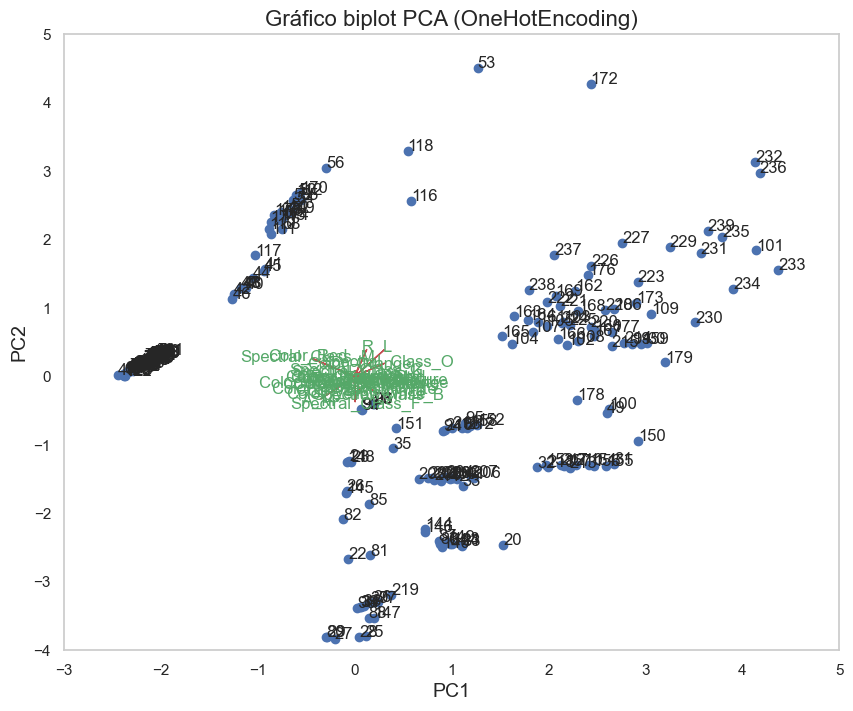

In [215]:
# Dibujar el biplot
plt.figure(figsize=(10, 8))
plt.xlim(-3, 5)
plt.ylim(-4, 5)
plt.xlabel("PC{}".format(1), size=14)
plt.ylabel("PC{}".format(2), size=14)
plt.title("Gráfico biplot PCA (OneHotEncoding)", size=16)
plt.grid()
biplot(X_scaled_one, PCA().fit(X_scaled_one),
       original_dim_labels=X_one.columns,
       point_labels=X_one.index)

Como se puede ver, con este método de codificación no se puede obtener una estructura clara. 

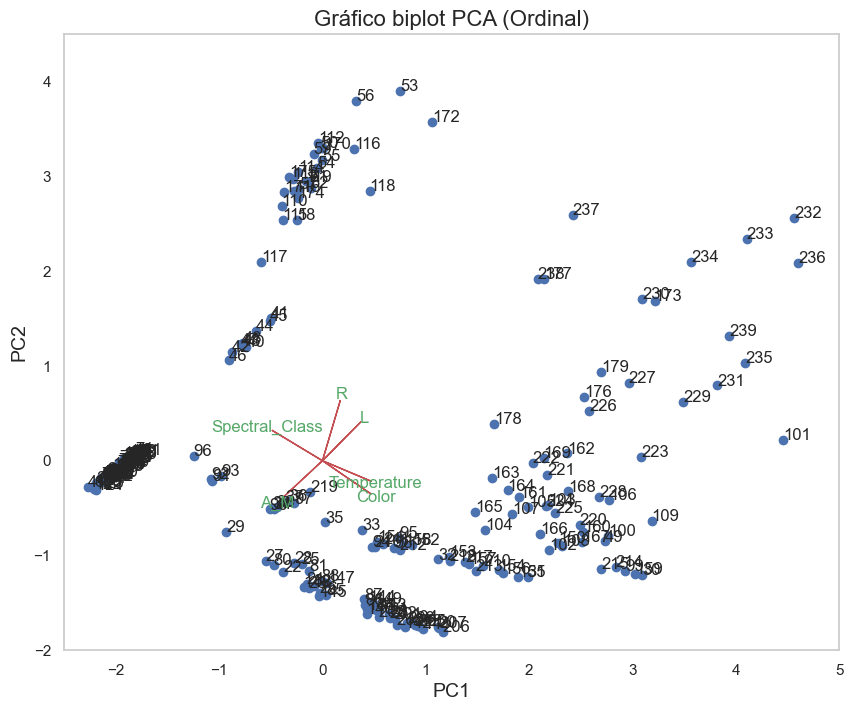

In [216]:
# Dibujar el biplot
plt.figure(figsize=(10, 8))
plt.xlim(-2.5, 5)
plt.ylim(-2, 4.5)
plt.xlabel("PC{}".format(1), size=14)
plt.ylabel("PC{}".format(2), size=14)
plt.title("Gráfico biplot PCA (Ordinal)", size=16)
plt.grid()
biplot(X_scaled_ord, PCA().fit(X_scaled_ord),
       original_dim_labels=X_ord.columns,
       point_labels=stars_df.index)

Como podemos ver en este otro gráfico, las características `Temperature` y `Color` tienen una alta correlación positiva, mientras que con `Spectral_Class` tienen una alta correlación negativa. Por otro lado, `R` y `L` tienen una alta correlación positiva, mientras que con `A_M` tienen una alta correlación negativa. Y entre ellas, es decir, entre `Temperature` y `L`, por ejemplo, no tienen nignuna correlación. 

**Conclusión**

Tras este breve e introductorio análisis para evaluar que método de codificación utilizaremos, hemos decidido optar por el método de codificación de variables ordinales. A continuación, realizaremos los distintos algoritmos y aplicaremos este método de codificación, además de utilizar este último modelo de PCA de dos componentes.

---
## Algoritmos de clustering
---

### <u>K–Means</u>

Como primer modelo utilizaremos el ya visto KMeans.

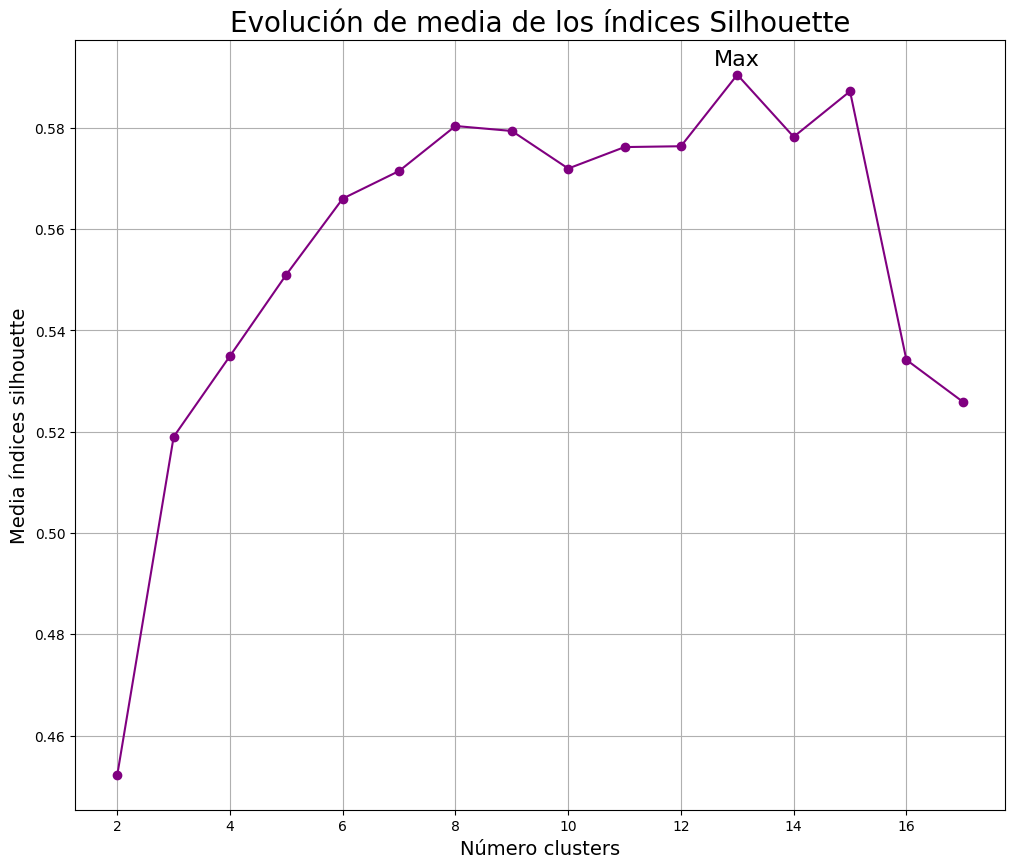

In [150]:
# -------------------------------------------------------------------------
# Número de clusters
# -------------------------------------------------------------------------

range_n_clusters = range(2, 18)
valores_medios_silhouette = []

for n_clusters in range_n_clusters:
    modelo = KMeans(
        n_clusters   = n_clusters,
        n_init       = 25,
        random_state = 49
    )
    cluster_labels = modelo.fit_predict(X_scaled_ord)
    silhouette_avg = silhouette_score(X_scaled_ord, cluster_labels)
    valores_medios_silhouette.append(silhouette_avg)

# Encontrar el número de clústeres con la puntuación de silueta máxima
max_silhouette_idx = np.argmax(valores_medios_silhouette)
max_silhouette_score = valores_medios_silhouette[max_silhouette_idx]
best_n_clusters = range_n_clusters[max_silhouette_idx]

# Método silueta para datos escalados
metodo_silueta(range_n_clusters, valores_medios_silhouette, best_n_clusters, max_silhouette_score+0.001)

Como podemos ver el número óptimo de clusters es 13, pero como ya sabemos por los científicos que hay 6 grupos de estrellas, cogeremos 6 clusters como valor óptimo. Además de que el valor es realmente cercano.

In [151]:
# Modelo
modelo_kmeans = KMeans(n_clusters=6, n_init=25, random_state=49)
# Entrenar el modelo
modelo_kmeans.fit(X=X_scaled_ord)

KMeans(n_clusters=6, n_init=25, random_state=49)

In [152]:
# Predicciones
y_pred_kmeans = modelo_kmeans.predict(X_scaled_ord)

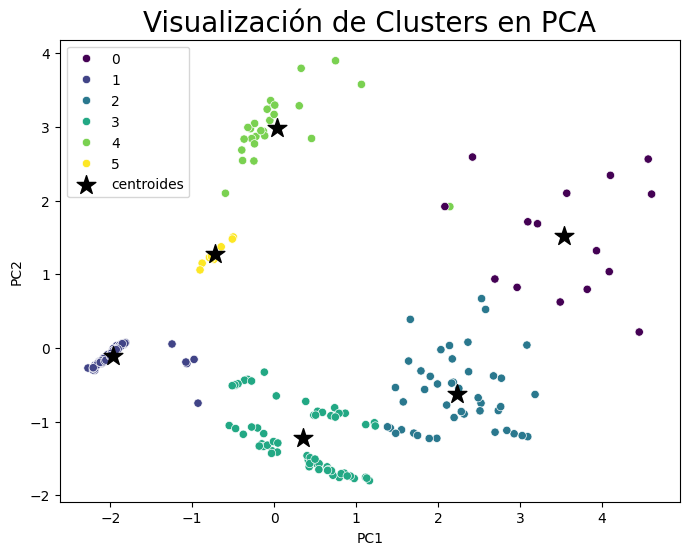

In [166]:
df_pca['Cluster'] = y_pred_kmeans
# Calcular los centroides
centroids = df_pca.groupby('Cluster').mean()[['PC1', 'PC2']]
# Crear el gráfico de dispersión
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='Cluster', palette='viridis')
plt.scatter(centroids['PC1'], centroids['PC2'], marker='*', s=200, linewidths=1, color='k', label='centroides')
plt.title('Visualización de Clusters en PCA', size=20)
plt.legend()
plt.show()

En general, el algoritmo muestra una buena precisión en la agrupación de los datos, con la excepción evidente de un punto que claramente no está ubicado donde se esperaría.

### <u>K–Medoids</u>

Otro modelo que se va a realizar es el KMedoids.

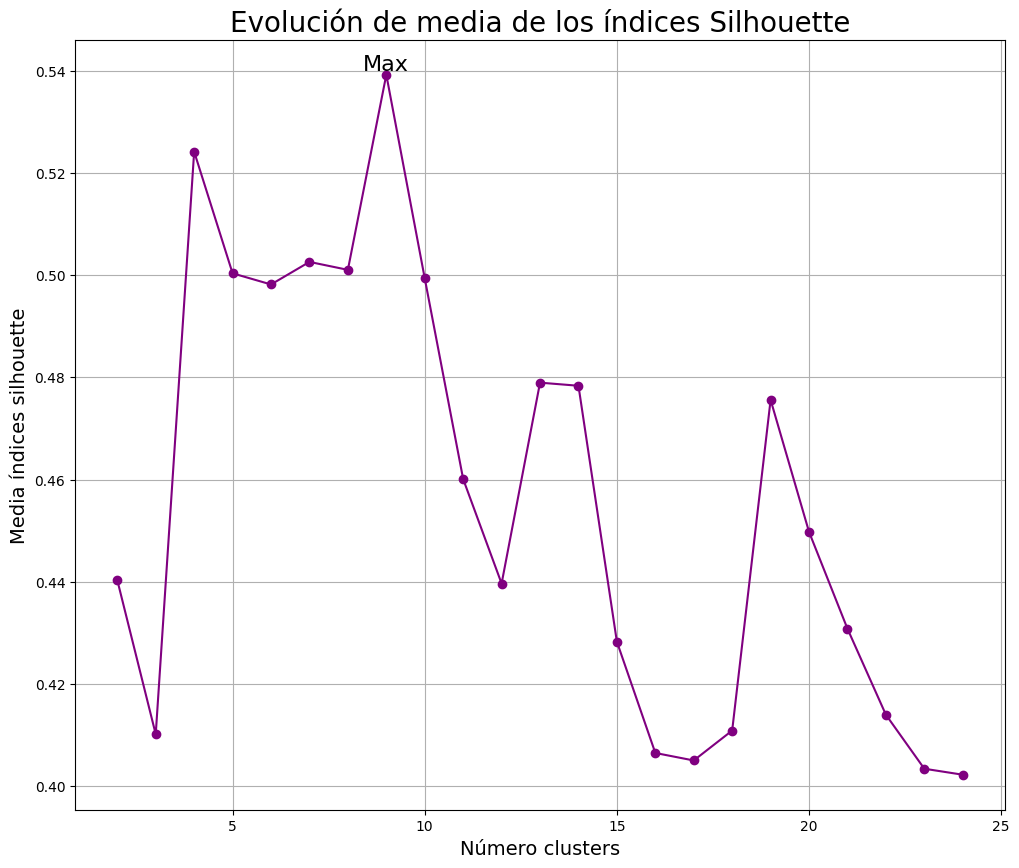

In [154]:
# -------------------------------------------------------------------------
# Número de clusters
# -------------------------------------------------------------------------

range_n_clusters = range(2, 25)
valores_medios_silhouette = []

for n_clusters in range_n_clusters:
    modelo = KMedoids(
        n_clusters   = n_clusters,
        random_state = 49
    )
    cluster_labels = modelo.fit_predict(X_scaled_ord)
    silhouette_avg = silhouette_score(X_scaled_ord, cluster_labels)
    valores_medios_silhouette.append(silhouette_avg)

# Encontrar el número de clústeres con la puntuación de silueta máxima
max_silhouette_idx = np.argmax(valores_medios_silhouette)
max_silhouette_score = valores_medios_silhouette[max_silhouette_idx]
best_n_clusters = range_n_clusters[max_silhouette_idx]

# Método silueta para datos escalados
metodo_silueta(range_n_clusters, valores_medios_silhouette, best_n_clusters, max_silhouette_score+0.0001)

El valor óptimo del número de clusters con el que se obtiene el mejor valor es 9, pero como utilizaremos 6 debido a que es el numero de grupos que obtuvieron los cientificos y relativamente el valor del índice de silhouette es cercano.

In [160]:
# Modelo
modelo_kmedoids = KMedoids(n_clusters=6, random_state=49)
# Entrenar el modelo
modelo_kmedoids.fit(X=X_scaled_ord)

KMedoids(n_clusters=6, random_state=49)

In [161]:
# Predicciones
y_pred_kmedoids = modelo_kmedoids.predict(X_scaled_ord)

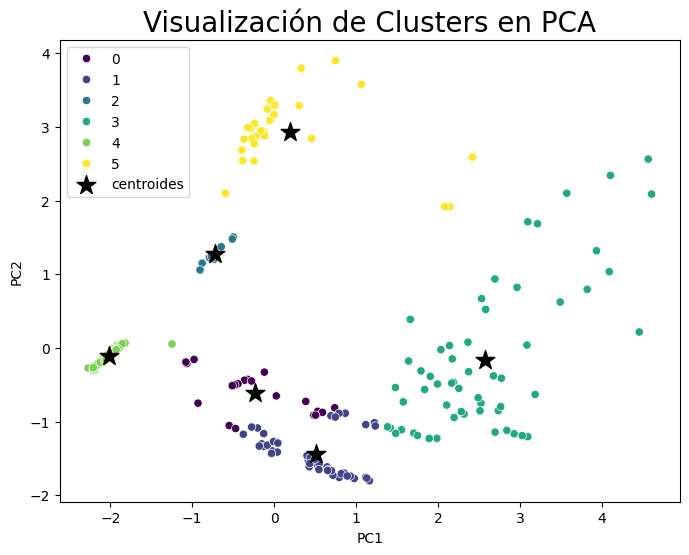

In [165]:
df_pca['Cluster'] = y_pred_kmedoids
# Calcular los centroides
centroids = df_pca.groupby('Cluster').mean()[['PC1', 'PC2']]
# Crear el gráfico de dispersión
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='Cluster', palette='viridis')
plt.scatter(centroids['PC1'], centroids['PC2'], marker='*', s=200, linewidths=1, color='k', label='centroides')
plt.title('Visualización de Clusters en PCA', size=20)
plt.legend()
plt.show()

Se obtiene un claramente peor resultado en la agrupación de los datos, los clusters resultantes no son del todo precisos.

### <u>Clustering jerárquico</u>

El siguiente modelo de clusterización es el jerárquico.

#### Dendograma

Método para representar el dendograma, se necesitará en este modelo de clusterización.

In [239]:
def plot_dendrogram(model, **kwargs):
    """ Esta función extrae la información de un modelo AgglomerativeClustering
    y representa su dendograma con la función dendogram de scipy.cluster.hierarchy """

    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot
    dendrogram(linkage_matrix, **kwargs)

Volviendo con el modelo, se realizarán los siguientes método de clusterización jerárquica, para luego representar su dendograma y elegir uno de ellos.

In [217]:
modelo_hclust_complete = AgglomerativeClustering(
    affinity = 'euclidean',
    linkage  = 'complete',
    distance_threshold = 0,
    n_clusters         = None
)
modelo_hclust_complete.fit(X=X_scaled_ord_df)

modelo_hclust_average = AgglomerativeClustering(
    affinity = 'euclidean',
    linkage  = 'average',
    distance_threshold = 0,
    n_clusters         = None
)
modelo_hclust_average.fit(X=X_scaled_ord_df)

modelo_hclust_ward = AgglomerativeClustering(
    affinity = 'euclidean',
    linkage  = 'ward',
    distance_threshold = 0,
    n_clusters         = None
)
modelo_hclust_ward.fit(X=X_scaled_ord_df)

AgglomerativeClustering(affinity='euclidean', distance_threshold=0,
                        n_clusters=None)

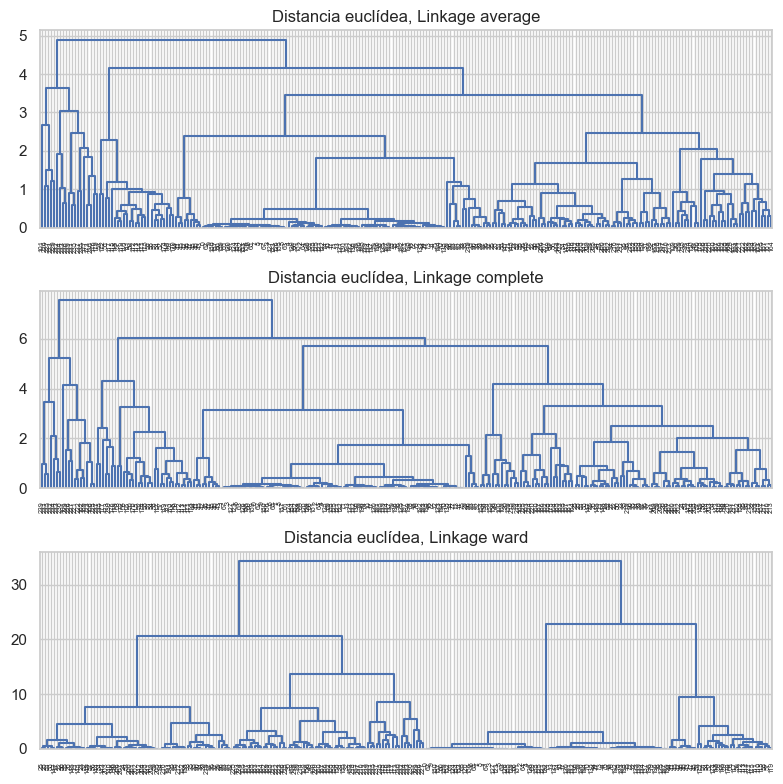

In [218]:
# -------------------------------------------------------------------------
# Dendogramas
# -------------------------------------------------------------------------

fig, axs = plt.subplots(3, 1, figsize=(8, 8))
plot_dendrogram(modelo_hclust_average, labels=X_scaled_ord_df.index, color_threshold=0, ax=axs[0])
axs[0].set_title("Distancia euclídea, Linkage average")
plot_dendrogram(modelo_hclust_complete, labels=X_scaled_ord_df.index, color_threshold=0, ax=axs[1])
axs[1].set_title("Distancia euclídea, Linkage complete")
plot_dendrogram(modelo_hclust_ward, labels=X_scaled_ord_df.index, color_threshold=0, ax=axs[2])
axs[2].set_title("Distancia euclídea, Linkage ward")
plt.tight_layout()

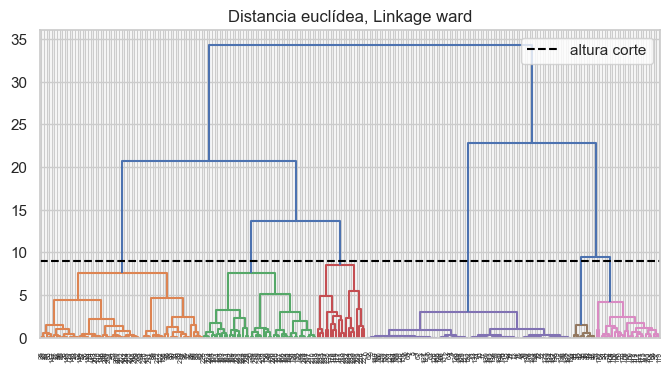

In [219]:
# -------------------------------------------------------------------------
# Número de clusters
# -------------------------------------------------------------------------

fig, ax = plt.subplots(1, 1, figsize=(8, 4))
altura_corte = 9
plot_dendrogram(modelo_hclust_ward, labels=X_scaled_ord_df.index, color_threshold=altura_corte, ax=ax)
ax.set_title("Distancia euclídea, Linkage ward")
ax.axhline(y=altura_corte, c = 'black', linestyle='--', label='altura corte')
ax.legend()

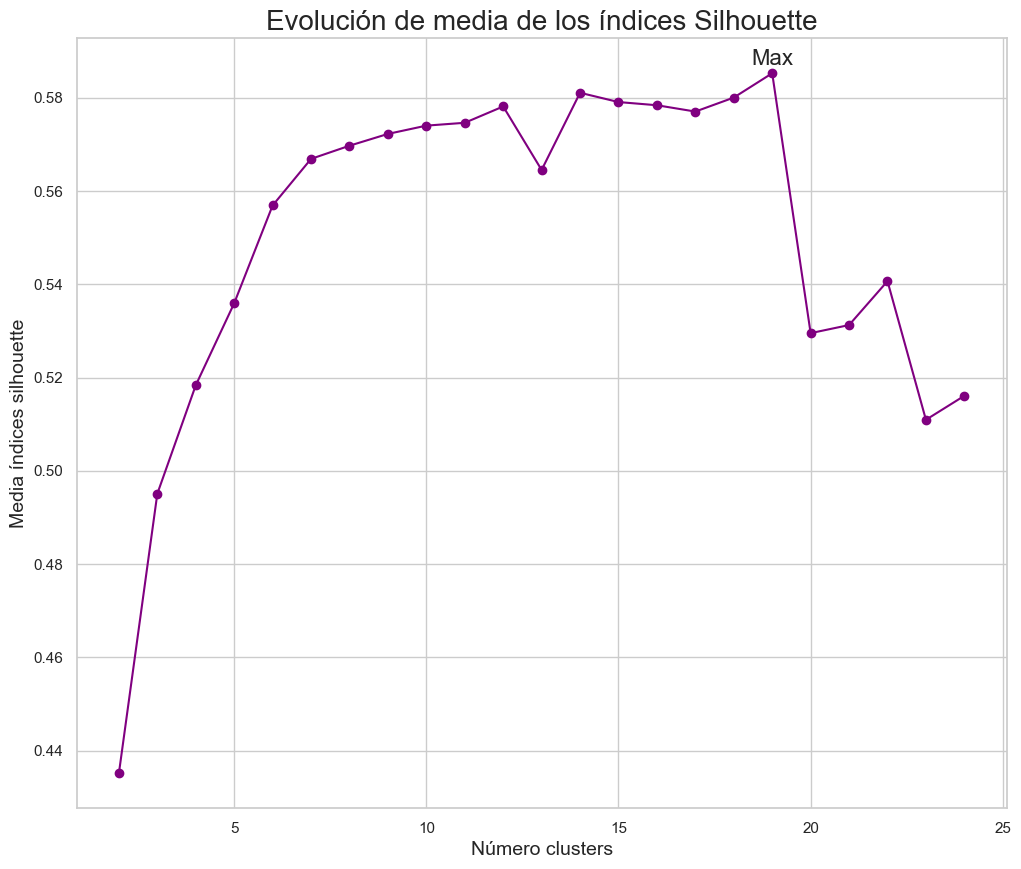

In [220]:
# -------------------------------------------------------------------------
# Número de clusters
# -------------------------------------------------------------------------

range_n_clusters = range(2, 25)
valores_medios_silhouette = []

for n_clusters in range_n_clusters:
    modelo = AgglomerativeClustering(
        affinity   = 'euclidean',
        linkage    = 'ward',
        n_clusters = n_clusters
    )

    cluster_labels = modelo.fit_predict(X_scaled_ord)
    silhouette_avg = silhouette_score(X_scaled_ord, cluster_labels)
    valores_medios_silhouette.append(silhouette_avg)

# Encontrar el número de clústeres con la puntuación de silueta máxima
max_silhouette_idx = np.argmax(valores_medios_silhouette)
max_silhouette_score = valores_medios_silhouette[max_silhouette_idx]
best_n_clusters = range_n_clusters[max_silhouette_idx]

# Método silueta para datos escalados
metodo_silueta(range_n_clusters, valores_medios_silhouette, best_n_clusters, max_silhouette_score+0.001)

Al igual que las anteriores, pese a que el valor óptimo obtenido con este método es 19 clusters, como el valor dado por los cientificos es 6 y la diferencia entre los valores del índice silhouette no es muy grande, se tomará este valor. Además para la creación del modelo de agrupamiento jerárquico se usará el método *Ward*.

In [221]:
modelo_hclust_ward = AgglomerativeClustering(
    affinity = 'euclidean',
    linkage  = 'ward',
    n_clusters = 6
)
modelo_hclust_ward.fit(X=X_scaled_ord)

AgglomerativeClustering(affinity='euclidean', n_clusters=6)

In [222]:
# Predicciones
y_pred_jerarq = modelo_hclust_ward.labels_

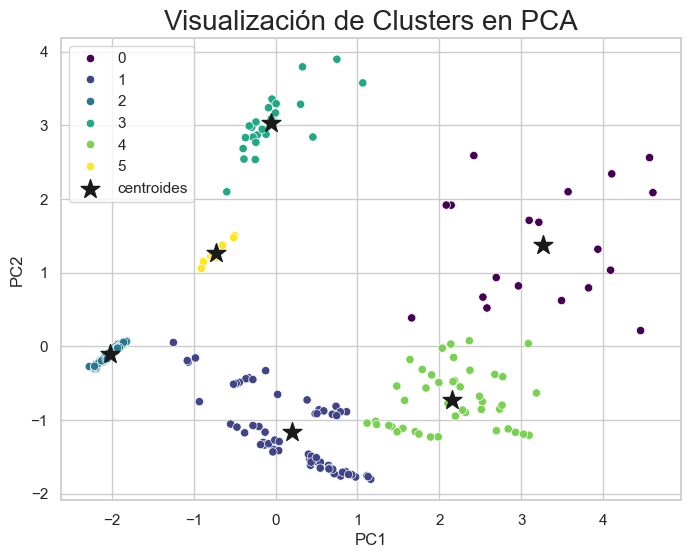

In [223]:
df_pca['Cluster'] = y_pred_jerarq
# Calcular los centroides
centroids = df_pca.groupby('Cluster').mean()[['PC1', 'PC2']]
# Crear el gráfico de dispersión
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='Cluster', palette='viridis')
plt.scatter(centroids['PC1'], centroids['PC2'], marker='*', s=200, linewidths=1, color='k', label='centroides')
plt.title('Visualización de Clusters en PCA', size=20)
plt.legend()
plt.show()

Como se puede apreciar en la gráfica, este modelo obtiene mejores resultados en la clusterización, son agrupaciones más precisas.

### <u>DBSCAN</u>

In [224]:
# Modelo
modelo_dbscan = DBSCAN(
    eps          = 0.8,
    min_samples  = 4,
    metric       = 'euclidean',
)

modelo_dbscan.fit(X=X_scaled_ord)

DBSCAN(eps=0.8, min_samples=4)

In [225]:
# Predicciones
y_pred_dbscan = modelo_dbscan.labels_

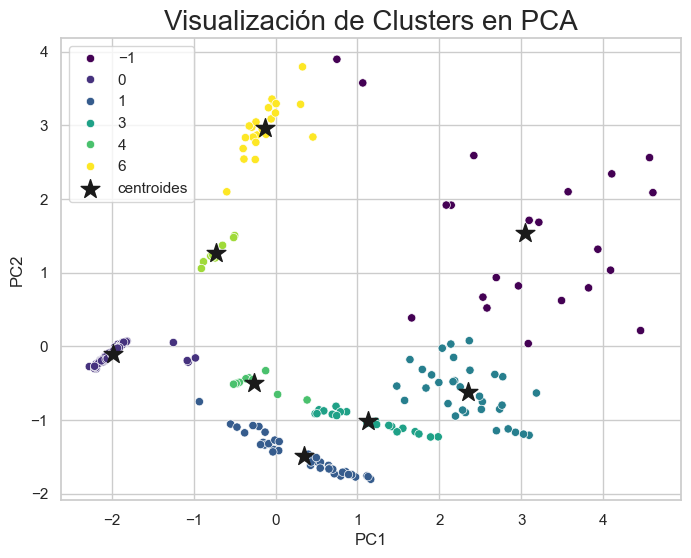

In [226]:
df_pca['Cluster'] = y_pred_dbscan
# Calcular los centroides
centroids = df_pca.groupby('Cluster').mean()[['PC1', 'PC2']]
# Crear el gráfico de dispersión
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='Cluster', palette='viridis')
plt.scatter(centroids['PC1'], centroids['PC2'], marker='*', s=200, linewidths=1, color='k', label='centroides')
plt.title('Visualización de Clusters en PCA', size=20)
plt.legend()
plt.show()

Como se puede observar, el cluster -1 son los *outliers*.

In [232]:
# Número de clusters y observaciones "outliers"
# ==============================================================================
n_clusters = len(set(y_pred_dbscan)) - (1 if -1 in y_pred_dbscan else 0)
n_noise    = list(y_pred_dbscan).count(-1)

print(f'Número de clusters encontrados: {n_clusters}')
print(f'Número de outliers encontrados: {n_noise}')

Número de clusters encontrados: 7
Número de outliers encontrados: 22


### <u>GMM</u>

Y por útimo, se realizará este modelo más.

In [233]:
modelo_gmm = GaussianMixture(n_components=6, covariance_type='full', random_state=49)
modelo_gmm.fit(X=X_pca)

GaussianMixture(n_components=6, random_state=49)

In [234]:
y_pred_gmm = modelo_gmm.predict(X_pca)

Text(0.5, 1.0, 'Distribución de prob. del modelo completo')

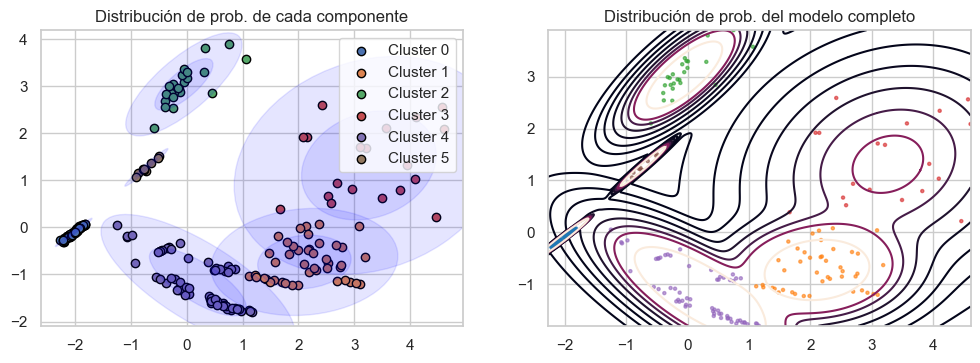

In [240]:
def make_ellipses(gmm, ax):
    for n in range(gmm.n_components):
        if gmm.covariance_type == 'full':
            covariances = gmm.covariances_[n]
        elif gmm.covariance_type == 'tied':
            covariances = gmm.covariances_
        elif gmm.covariance_type == 'diag':
            covariances = np.diag(gmm.covariances_[n])
        elif gmm.covariance_type == 'spherical':
            covariances = np.eye(gmm.means_.shape[1]) * gmm.covariances_[n]
        v, w = np.linalg.eigh(covariances)
        u = w[0] / np.linalg.norm(w[0])
        angle = np.arctan2(u[1], u[0])
        angle = 180 * angle / np.pi  # convert to degrees
        v = 2. * np.sqrt(2.) * np.sqrt(v)

        for i in range(1,3):
            ell = mpl.patches.Ellipse(gmm.means_[n], i*v[0], i*v[1],
                                      180 + angle, color="blue")
            ell.set_clip_box(ax.bbox)
            ell.set_alpha(0.1)
            ax.add_artist(ell)


fig, axs = plt.subplots(1, 2, figsize=(12, 3.84))

# Distribución de probabilidad de cada componente
for i in np.unique(y_pred_gmm):
    axs[0].scatter(
        x = X_pca[y_pred_gmm == i, 0],
        y = X_pca[y_pred_gmm == i, 1],
        c = plt.rcParams['axes.prop_cycle'].by_key()['color'][i],
        marker    = 'o',
        edgecolor = 'black',
        label= f"Cluster {i}"
    )

make_ellipses(modelo_gmm, ax = axs[0])
axs[0].set_title('Distribución de prob. de cada componente')
axs[0].legend()

# Distribución de probabilidad del modelo completo
xs = np.linspace(min(X_pca[:, 0]), max(X_pca[:, 0]), 1000)
ys = np.linspace(min(X_pca[:, 1]), max(X_pca[:, 1]), 1000)
xx, yy = np.meshgrid(xs, ys)
scores = modelo_gmm.score_samples(np.c_[xx.ravel(), yy.ravel()], )
axs[1].scatter(X_pca[:, 0], X_pca[:, 1], s=5, alpha=.6, c=plt.cm.tab10(y_pred_gmm))
scores = np.exp(scores) # Las probabilidades están en log
axs[1].contour(
    xx, yy, scores.reshape(xx.shape),
    levels=np.percentile(scores, np.linspace(0, 100, 10))[1:-1]
)
axs[1].set_title('Distribución de prob. del modelo completo')

Como se puede ver, este modelo es el que proporciona más detalle de los clusters que obtiene como resultado. Además, parece ser el que realiza las predicciones con más precisión, por lo que se va a tomar como modelo final.

---
## Modelo final.
---


A continuación, realizaremos el modelo final elegido como el mejor y su comparación correspondiente con el grupo de estrellas obtenido por los cientificos.

In [241]:
# Modelo final
modelo_final = GaussianMixture(n_components=6, covariance_type='full', random_state=49)
# Entrenar el modelo
modelo_final.fit(X=X_pca)
# Predicciones
y_pred_final = modelo_final.predict(X_pca)

In [237]:
# DataFrame con los resultados
X_ord_df = pd.DataFrame(X_ord, columns=stars_df.columns, index=stars_df.index)

### <u>Box–plot</u>

Ahora se procede a mostrar los boxplot de cada variable para estudiar una posible similitud a la tabla propuesta por los científicos.

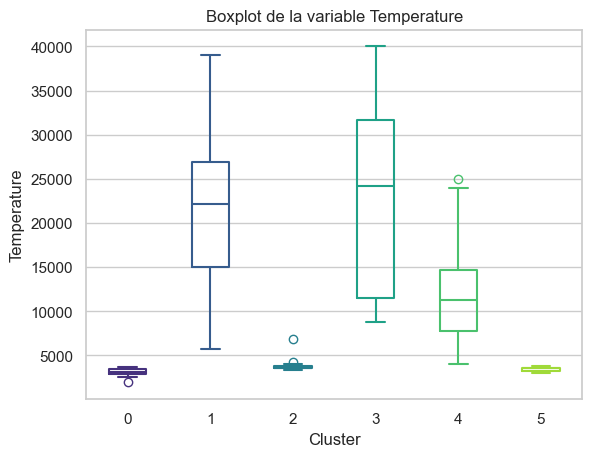

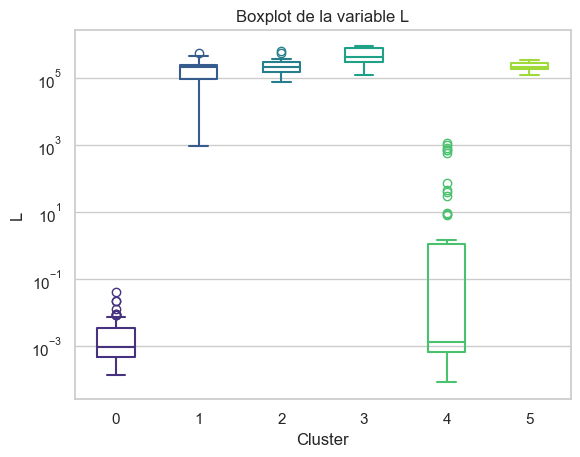

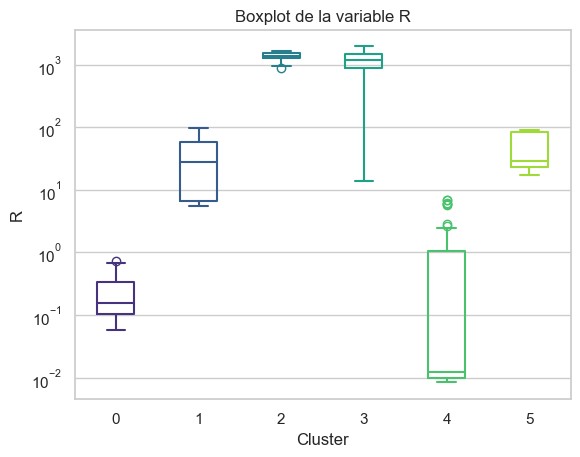

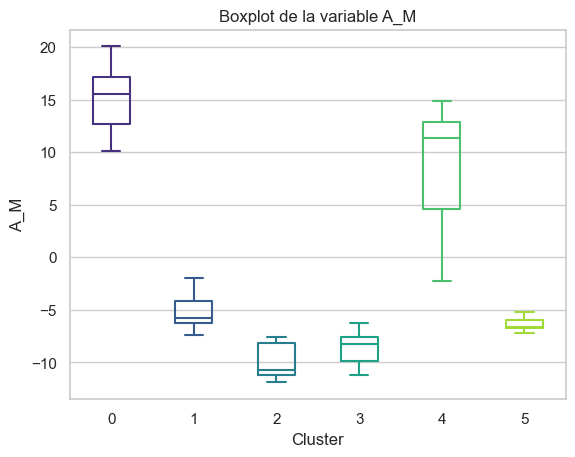

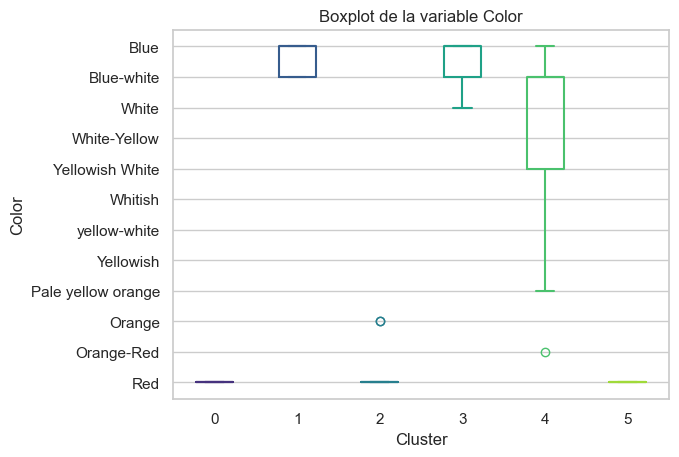

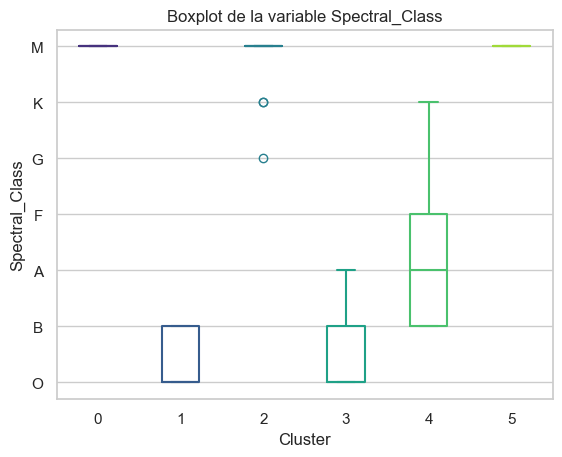

In [242]:
datos = X_ord_df.copy()
datos["Cluster"] = y_pred_gmm

aux=datos.columns.tolist()

for col in aux[0:len(aux)-1]:
    sns.set(style="whitegrid")
    sns.boxplot(data=datos, x="Cluster", y=col, fill=False, gap=.1, width=0.5, palette='viridis')
    if col == "L" or col == "R":
        plt.yscale('log')
    elif col == "Color":
        plt.yticks(np.arange(0, 12, 1), colors)
    elif col == "Spectral_Class":
        plt.yticks(np.arange(0, 7, 1), spectral_class)
    plt.title(f"Boxplot de la variable {col}")
    plt.show()

A la vista de estos resultados podemos identificar algunas estrellas de la tabla propuesta por los científicos. 

- `Cluster 0` coincide exactamente con **estrella enana marrón** ya que coinciden los valores de todas las variables con los valores de la tabla de los científicos.

- `Cluster 1` puede asemejarse a **estrella supergigante**, coinciden en los valores de todas las variables a excepción del color, se encuentra cercana al color de este tipo de estrellas. 

- `Cluster 2` posiblemente se corresponde con **estrella enana roja**, aunque las variables de lumninosidad y radio no correspondan con dicha tabla.

- `Cluster 3` es probablemente **estrella hipergigante**, conciden todas las variables a excepcion de la clase espectral y el color.

- `Cluster 4` se corresponde con **estrella enana blanca**, ya que todas las variables coinciden en valor a los expuestos en la tabla.

- `Cluster 5` podría tratarse de **estrella en secuencia principal**, pero es la que menos coincide con los datos proporcionados por los científicos. 